In [1]:
import string
import pandas as pd
import numpy
import nltk
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
stemmer = PorterStemmer()
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib as mpl

# Function for loading the dataset

Load the dataset and split it into training (80%) and test (20%):

In [2]:
def load_food_dataset():
    '''Standard test dataset for recommendation systems
    From https://www.kaggle.com/snap/amazon-fine-food-reviews
    '''
    folder = './data/'
    foodreviews = pd.read_csv(folder + 'Reviews.csv.zip', nrows = 200000)
    foodreviews = foodreviews.rename(columns={'HelpfulnessNumerator': 'VotesHelpful', 'HelpfulnessDenominator': 'VotesTotal'})
    foodreviews = foodreviews.drop(['Id','ProductId','UserId','ProfileName','Time'], axis=1)

    scores = foodreviews['Score'].values
    foodreviews = foodreviews.drop('Score', axis=1)

    return foodreviews, scores

# Text processing functions

In [3]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text) #break text into tokens
    stems = stem_tokens(tokens, stemmer) #convert tokens to their stems
    return ' '.join(stems)

def normalize_text(textvector):
    intab = string.punctuation #returns a string of all ASCII punctuation charaters 
    outtab = "                                "
    trantab = str.maketrans(intab, outtab) #maps punctuation charachers with spaces

    corpus = []
    for text in textvector:
        text = str(text).lower() #make all lower case
        text = text.translate(trantab) #remove punctuation
        text=tokenize(text) #convert indidual text instances into stemmed tokens
        corpus.append(text) # form a full corpus of stemmed tokens of the model
        
    text_counts = CountVectorizer().fit_transform(corpus)   #learn the vocabulary and return term-document matrix      
    text_tfidf = TfidfTransformer().fit_transform(text_counts) #convert into term-frequency * inverse document-frequency matrix
    
    return corpus, text_tfidf

# Function for making word clouds 

In [4]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0) 
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

# Factroization machine models:

### MCMC:
(It allows to intergrate the regularizarion parameters into the model)

In [5]:
from fastFM import mcmc
from fastFM.mcmc import FMRegression
def mcmc_fastfm(trainX, trainY, testX, rank=8, n_iter=100):
    clf = FMRegression(rank=rank, n_iter=n_iter)
    return clf.fit_predict(trainX, trainY, testX) 

### Alternating least squares (ALS):
(very easy to parallelize; SGD is not practical when (users)x(items) are in the order of billions --> ALS is a much more efficient optimization technique then)

In [6]:
from fastFM import als
def als_fastfm(trainX, trainY, testX):
    fm = als.FMRegression(n_iter=100, init_stdev=0.1, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)
    fm.fit(trainX, trainY)
    return fm.predict(testX)

# Some other models:

### Naive Bayes:

In [7]:
from sklearn.naive_bayes import MultinomialNB
def mult_naive_bayes(trainX, trainY, testX):
    model = MultinomialNB().fit(trainX, trainY)
    return model.predict(testX)        

### Ridge regression model:

In [8]:
from sklearn.linear_model import LogisticRegression, Ridge
def ridge_regression(trainX, trainY, testX, classification=True, **params):
    clf = Ridge(**params)
    clf.fit(trainX, trainY)
    return clf.predict(testX)

# Putting it all together:

### Let's load the dataset first and perform textual content processing

In [10]:
X, y = load_food_dataset()

norm_sum, X_tfidf_sum = normalize_text(X['Summary'])
norm_text, X_tfidf_text = normalize_text(X['Text'])

FileNotFoundError: [Errno 2] No such file or directory: './data/Reviews.csv.zip'

### Just out of curiosity let's take a look for the word clouds for the best and worst food scores

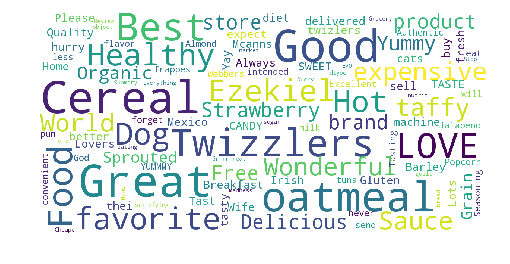

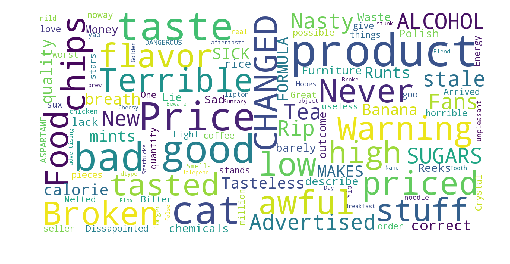

In [306]:
combined = X
combined['Score'] = y

max_rating = combined[combined['Score']==5]
show_wordcloud(max_rating['Summary'])

min_rating = combined[combined['Score']==1]
show_wordcloud(min_rating['Summary'])

# It's time to try different models:

### Factorization machine with MCMC

Tried using "Summary" or "Text" as input. Using "Summary" seems to work better. For other models used only "Summary" 

In [307]:
import time
from sklearn.metrics import mean_squared_error 

# train based on "Summary" column
trainX, testX, trainY, testY = train_test_split(X_tfidf_sum, y, train_size=0.8, random_state=42)

start = time.time()
prediction = mcmc_fastfm(trainX, trainY, testX)
predictionMCMC = prediction
spent_time = time.time() - start

results = pd.DataFrame()
name = 'MCMC fastFM regression using "Summary"'
results.ix[name, 'time'] = spent_time
results.ix[name, 'RMSE'] = numpy.sqrt(mean_squared_error(testY, prediction))

# train based on "Text" column
trainX, testX, trainY, testY = train_test_split(X_tfidf_text, y, train_size=0.8, random_state=21)
start = time.time()
prediction = mcmc_fastfm(trainX, trainY, testX)
spent_time = time.time() - start

name = 'MCMC fastFM regression using "Text"'
results.ix[name, 'time'] = spent_time
results.ix[name, 'RMSE'] = numpy.sqrt(mean_squared_error(testY, prediction))

### Factorization machine with ALS

In [308]:
start = time.time()
prediction = als_fastfm(trainX, trainY, testX)
spent_time = time.time() - start

name = 'fastFM regression with ALS using "Summary"'
results.ix[name, 'time'] = spent_time
results.ix[name, 'RMSE'] = numpy.sqrt(mean_squared_error(testY, prediction))

### Other models to try:
### Naive Bayes (usually used for classification so don't expect great results here)

In [309]:
trainX, testX, trainY, testY = train_test_split(X_tfidf_sum, y, train_size=0.8, random_state=99)

start = time.time()
prediction = mult_naive_bayes(trainX, trainY, testX)
spent_time = time.time() - start

name = 'Naive Bayes'
results.ix[name, 'time'] = spent_time
results.ix[name, 'RMSE'] = numpy.sqrt(mean_squared_error(testY, prediction))

### Ridge regression:
(regression model where the loss function is the linear least squares function and regularization is given by the l2-norm)

In [310]:
start = time.time()
prediction = ridge_regression(trainX, trainY, testX, classification=False)
spent_time = time.time() - start

name = 'Ridge regression using "Summary"'
results.ix[name, 'time'] = spent_time
results.ix[name, 'RMSE'] = numpy.sqrt(mean_squared_error(testY, prediction))

### Let's compare the models:

In [311]:
results

,time,RMSE
"MCMC fastFM regression using ""Summary""",20.087884,0.835778
"MCMC fastFM regression using ""Text""",193.120488,0.892622
"fastFM regression with ALS using ""Summary""",67.441139,0.939427
Naive Bayes,0.077872,1.264140
"Ridge regression using ""Summary""",1.270118,0.909197


Factorization machines with MCMC algorithm look like a winner. There is a caveat though that the models have been pretty much taken "as is" with default parameter and an advantage of MCMC is that the regularization is done automatically. 

The parameters of other models and of MCMC apart from regularization should be explored using, for example, the scikit-learn GridSearchCV module.

Finally, taking a look at the distributions of true and predicted scores one can see that the MCMC didn't really do a good job at predicting the worst scores (big discrepancy in the disctibution for score = 1)

Populating the interactive namespace from numpy and matplotlib


/storage/git/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


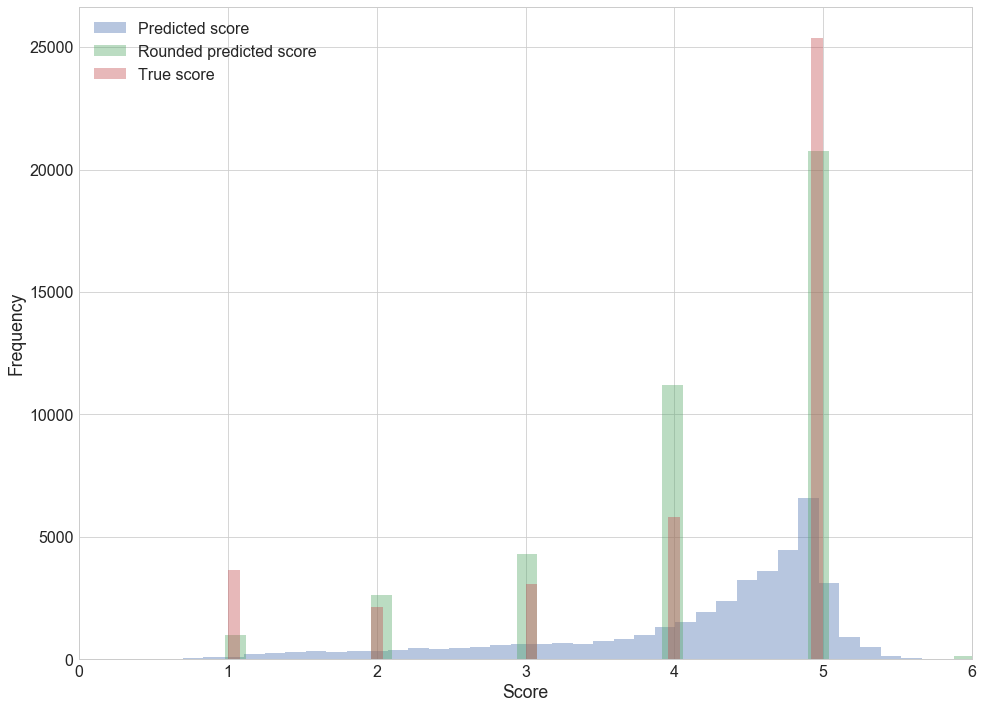

In [312]:
output = pd.DataFrame(data=[predictionMCMC, testY]).T
output.columns = ['Prediction', 'Truth']

import seaborn as sns
sns.set(color_codes=True)
%pylab inline
plt.figure(figsize=(16, 12))
sns.set(context='paper', font_scale=2, style='whitegrid')

dist = sns.distplot(output['Prediction'], label = 'Predicted score', kde=False)
dist = sns.distplot(np.round(output['Prediction']), label = 'Rounded predicted score', kde=False)
dist = sns.distplot(output['Truth'], label = 'True score', kde=False)
dist.set(xlabel='Score', ylabel='Frequency', xlim=(0, 6))
dist.legend()

results = 0

The following sources were used to put this notebook together:

Github of the fastFM library: http://ibayer.github.io/fastFM/index.html

Scikit-learn "Working with text tutorial": http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

Kaggle dataset for Amazon food reviews:
https://www.kaggle.com/snap/amazon-fine-food-reviews and some nice notebooks there:
https://www.kaggle.com/eugen1701/predicting-sentiment-and-helpfulness, https://www.kaggle.com/gpayen/building-a-prediction-model

Very useful blog http://arogozhnikov.github.io/ on machine learning and particularly this post:
http://arogozhnikov.github.io/2016/02/15/TestingLibFM.html#What-is-tested